In [15]:
import pandas as pd
import datetime as dt
import numpy as np

In [2]:
from google.colab import drive
import os

In [3]:
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
root_dir="/content/gdrive/My Drive/Shopify"

## Question 1. AOV Calculation

In [14]:
df = pd.read_excel(root_dir+"/2019 Winter Data Science Intern Challenge Data Set.xlsx", parse_dates=True)
df

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56.190
1,2,92,925,90,1,cash,2017-03-03 17:38:51.999
2,3,44,861,144,1,cash,2017-03-14 04:23:55.595
3,4,18,935,156,1,credit_card,2017-03-26 12:43:36.649
4,5,18,883,156,1,credit_card,2017-03-01 04:35:10.773
...,...,...,...,...,...,...,...
4995,4996,73,993,330,2,debit,2017-03-30 13:47:16.597
4996,4997,48,789,234,2,cash,2017-03-16 20:36:16.389
4997,4998,56,867,351,3,cash,2017-03-19 05:42:42.228
4998,4999,60,825,354,2,credit_card,2017-03-16 14:51:18.188


In [21]:
df.created_at.dt.year.value_counts()
df.created_at.dt.month.value_counts()
#The above lines of code confirm the data is for only 1 month that is March 2017 and for 31 days.

3    5000
Name: created_at, dtype: int64

In [23]:
# How the problem statement is calculating AOV :
total_revenue = sum(df['order_amount'])
total_orders = len(df)
AOV = total_revenue/total_orders
print("Problem statement's calculated AOV : $",AOV)

Problem statement's calculated AOV : $ 3145.128


According to Shopify, "Average Order value refers to the average amount of money each customer spends per transcation at the store."
However, Since the AOV was naively calculated, the process doesnt check for a few potential problems like:
1. Are there repeated values in the dataset? In other words, is the dataset consisted of only unique transactions and free from error?
2. Are there any outliers in the dataset? Is there any specific order, which is having a dominating effect on AoV?
3. Is there a huge difference between the maximum value of order amount and minimum value of order amount?

The above two questions can be solved with some preprocessing on data.

In [25]:
#how many repeated transactions are there?
duplicates = df[df.duplicated(['created_at', 'shop_id','user_id','order_amount','total_items','payment_method'])]
duplicates

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
2297,2298,42,607,704000,2000,credit_card,2017-03-07 04:00:00
2969,2970,42,607,704000,2000,credit_card,2017-03-28 04:00:00
3332,3333,42,607,704000,2000,credit_card,2017-03-24 04:00:00
4056,4057,42,607,704000,2000,credit_card,2017-03-28 04:00:00
4646,4647,42,607,704000,2000,credit_card,2017-03-02 04:00:00


The above line of code, provides answer to the first question. Since there are duplicates in the dataset, just averaging all orders will not help.

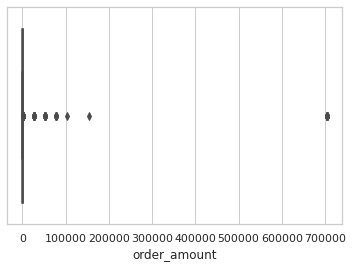

In [40]:
# Q2. Outliers in the dataset. We will answer this question using boxplots, a means of visualizing the dataset to identify outliers.
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.boxplot(x=df['order_amount'])
plt.show()

Since we can see outliers, we will later detect them and remove them.

In [41]:
# Q3. Is there a huge difference between the minimum and the maximum order_amount?
min_amt = min(df['order_amount'])
max_amt = max(df['order_amount'])
difference = max_amt - min_amt
print("The difference in amounts is: $", difference, "with maximum amount : $", max_amt, " and minimum amount : $", min_amt)

The difference in amounts is: $ 703910 with maximum amount : $ 704000  and minimum amount : $ 90


The above shows that the order amounts are not standardized and they need to be handled before any kind of metric evaluation.

Below is the proposed solution to solve for the incorrect metric:
1. Since there are a lot of outliers, it would be best to remove them or replace them with the mean. 
2. Standardize the data with a MinMax Scalar, if you dont want to deal with outliers.
3. Address the outlier issue with "total_items" since, it is directly related to "order_amount"

In [42]:
# Using InterQuartile ranges for outlier detection
Q1 = df.order_amount.quantile(0.25)
Q3 = df.order_amount.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

227.0


In [57]:
cleaned = df.loc[(df.order_amount > Q1) & (df.order_amount < Q3)]
cleaned

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56.190
7,8,22,761,292,2,cash,2017-03-08 02:05:37.981
8,9,64,914,266,2,debit,2017-03-17 20:56:50.468
10,11,66,848,322,2,credit_card,2017-03-26 23:36:39.877
11,12,40,983,322,2,debit,2017-03-12 17:58:30.356
...,...,...,...,...,...,...,...
4995,4996,73,993,330,2,debit,2017-03-30 13:47:16.597
4996,4997,48,789,234,2,cash,2017-03-16 20:36:16.389
4997,4998,56,867,351,3,cash,2017-03-19 05:42:42.228
4998,4999,60,825,354,2,credit_card,2017-03-16 14:51:18.188


In [58]:
#Now calculating AOV Again for this new dataset
total_revenue = sum(cleaned['order_amount'])
total_orders = len(cleaned)
AOV = total_revenue/total_orders
print("Corrected AOV : $",AOV)

Corrected AOV : $ 275.4128926968584


The Corrected AOV of **$275.5** makes more sense now and looks affordable.


#### However, since we are unaware of the context behind the data, that is there is a possibility that shop_id 42 is a warehouse and the customer it is shipping to is a store, buying such huge amount of sneakers would make sense. Hence another metric can be used here. That is "Average Basket Value". 

#### According to shopify, " Average Basket Value tells how many items are typically sold per transaction".
**This metric makes more sense, specially if we dont want to deal with the problems of AOV as discussed before.**

### Average Basket Value

In [59]:
total_items_sold = sum(df['total_items'])
total_transactions = len(df)
ABV = total_items_sold/total_transactions
print("The Average Basket Value is $", ABV)

The Average Basket Value is $ 8.7872


## Question 2. SQL

#### Q1. How many orders were shipped by Speedy Express in total?

In [60]:
##The following queries are written in MySQL 

    Select Distinct(OrderID)
    from Orders 
    where Orders.ShipperID in 
    (SELECT ShipperID FROM Shippers 
    where ShipperName like "%Speedy Express%")





**Output:** 54

#### Q2. What is the last name of the employee with the most orders?

    Select LastName from Employees 
    where EmployeeID in 
    (SELECT EmployeeID 
    FROM Orders  GROUP BY EmployeeID 
    HAVING COUNT (EmployeeID)=
    (SELECT MAX(ordercount) FROM 
    (SELECT EmployeeID, COUNT(OrderID) ordercount 
    FROM orders
    GROUP BY EmployeeID)))


**Output:** Peacock

#### Q3. What product was ordered the most by customers in Germany?

    Select ProductName from Products where ProductID in 
      (select ProductID from 
        (Select ProductID ,Max(ProductCount) as MaxCount from 
          (Select ProductID, count(ProductID) as ProductCount from OrderDetails where OrderID in 
            (Select OrderID from Orders where CustomerID in (SELECT CustomerID from Customers where Country like "%Germany%")) group by ProductID)))

**Output:**  Gorgonzola Telino